<font size=6, color=blue>__MLPClassifier__</font>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import math
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.datasets import load_digits
import copy
from mlxtend.evaluate import confusion_matrix as cm
from yellowbrick.classifier import ClassificationReport

In [2]:
def initializeTheta(in_, out_):
    Theta = np.asarray(np.random.randn(in_, out_)*np.sqrt(2.0/in_))
    #Theta = np.random.rand(in_,out_)
    return Theta

In [3]:
def logistic(z):
    z = np.asarray(z)
    return np.asarray(1/(1+np.exp(-z)))

def logistic_gradient(z):
    return np.asarray(logistic(z)*(1-logistic(z)))

In [4]:
def relu(z):
    z = np.asarray(z)
    return np.maximum(0, z)

In [5]:
def relu_gradient(z):
    return np.array([0 if i <= 0 else 1 for i in z])

In [6]:
def tanh(z):
    z = np.asarray(z)
    return np.asarray(2/(1+np.exp(-2*z))-1)

In [7]:
def activate(activation, z):
    if activation == 'logistic':
        return logistic(z)
    if activation == 'relu':
        return relu(z)
    if activation == 'tanh':
        return tanh(z)
    
def regularize(regularizer, loss, alpha, Theta1, Theta2):
    if regularizer == 'None':
        return loss
    if regularizer == 'l2':
        Theta1_reg = np.sum(np.square(Theta1[:][1:]))
        Theta2_reg = np.sum(np.square(Theta2[:][1:]))
        reg = Theta1_reg+Theta2_reg
        return loss+(alpha/2.0)*reg
    
def regularize_weights(regularizer, Theta1, Theta2, lambd):
    if regularizer == None:
        return Theta1, Theta2
    if regularizer == 'l1':
        return lambd*np.sign(Theta1[1:, :]), lambd*np.sign(Theta2[1:, 1])
    if regularizer == 'l2':
        return lambd*Theta1[1:, :], lambd*Theta2[1:, :]

In [8]:
def softmax(a):
    return np.asarray((np.exp(a)/np.sum(np.exp(a))))

def cross_entropy_loss(y_one_hot, y_pred, y_proba):
    loss = 0
    for i in range(len(y_one_hot)):
        for c in range(len(y_proba[0])):
            loss += y_one_hot[i][c]*np.log(y_proba[i][c])
    return -loss

def one_hot_labels(y):
    unique_list = np.unique(y)
    columns = len(unique_list)
    rows = len(y)
    y_encoded = np.zeros((rows, columns)).astype(int)
    for i in range(rows):
        for j,val in enumerate(unique_list):
            if y[i] == val:
                y_encoded[i][j] = 1
    return y_encoded

def softmax_gradient(a):
    return np.asarray(softmax(a)*(1-softmax(a)))

In [9]:
#calculate tp, fp, tn, fn
#Function that returns accuracy and generalization error of two vectors
def accu_error(x, x_predict):
    #g_error = np.mean((np.subtract(x, x_predict))**2)
    #accu = 1 - g_error
    c_m = cm(x, x_predict, binary = False)
    accu = np.trace(c_m)/len(x)
    err = 1 - accu
    return accu, err

def values(x, x_predict):
    true_positive = 0.0
    false_positive = 0.0
    true_negative = 0.0
    false_negative = 0.0
    for i in range(len(x)):
        if np.logical_and(x_predict[i] == 1, x[i] == 1):
        #if x_predict[i] == 1 & x[i] == 1:
            true_positive += 1
        if np.logical_and(x_predict[i] == 1, x[i] == 0):
            false_positive += 1
        if np.logical_and(x_predict[i] == 0, x[i] == 0):
            true_negative += 1
        if np.logical_and(x_predict[i] == 0, x[i] == 1):
            false_negative += 1
          
    if(true_positive+false_negative == 0):
        tpr = 0.0
    else:
        tpr = (true_positive)/(true_positive+false_negative)
    if(false_positive+true_negative == 0):
        fpr = 0.0
    else:
        fpr = (false_positive)/(false_positive+true_negative)

    return [true_positive, false_positive, true_negative, false_negative, tpr, fpr]

#Function to compute precision
def precision(c_m):
    tp = np.diagonal(c_m)
    fp = np.sum(c_m,axis=0) - tp
    return tp/(tp + fp)

#Function to compute recall
def recall(c_m):
    tp = np.diagonal(c_m)
    fn = np.sum(c_m,axis=1) - tp
    return tp/(tp + fn)

#Function to compute f1
def f1_score(c_m):
    f1 = 2*((precision(c_m)*recall(c_m))/(precision(c_m)+recall(c_m)))
    return f1

#Function to compute confusion matrix
def confusion_matrix(y, y_predict):
    confusion_matrix = [[], []]
    confusion_matrix[0].append(values(x, x_predict)[2])
    confusion_matrix[0].append(values(x, x_predict)[1])
    confusion_matrix[1].append(values(x, x_predict)[3])
    confusion_matrix[1].append(values(x, x_predict)[0])
    return np.asarray(confusion_matrix)

In [10]:
class MLPClassifier:
    
    def partitions(self, X, y, t):
        test_rows_X = math.ceil(len(X)*t)
        test_rows_y = math.ceil(len(y)*t)
        train_rows_X = len(X) - test_rows_X
        train_rows_y = len(y) - test_rows_y
        #X_train = X.iloc[:train_rows_X]
        #X_test = X.iloc[train_rows_X:]
        X_train = X[0:train_rows_y]
        X_test = X[train_rows_y:len(y)]
        y_train = y[0:train_rows_y]
        y_test = y[train_rows_y:len(y)]

        return np.asarray([X_train, y_train, X_test, y_test])
    
    def FeedForward(self, X, Theta1, Theta2, single):
        #a1 = np.c_[np.ones((len(X), 1)), X]
        #print(a1.shape)
        if single == True:
            a1 = np.insert(X, 0, 1)
            a1 = a1.T
            z2 = np.dot(a1, Theta1) # sample by feature(layer 2)
            a2 = activate(self.activation, z2)
            #a2 = np.c_[np.ones((len(X), 1)), a2]
            a2 = np.insert(a2, 0, 1)
            z3 = np.dot(a2, Theta2)
            a3 = softmax(z3)
        else:
            a1 = np.c_[np.ones((len(X), 1)), X]
            z2 = np.dot(a1, Theta1) # sample by feature(layer 2)
            a2 = activate(self.activation, z2)
            a2 = np.c_[np.ones((len(X), 1)), a2]
            z3 = np.dot(a2, Theta2)
            a3 = softmax(z3)
        return [a1, z2, a2, z3, a3]

    
    def fit(self, X, y, hidden_layer_neurons=2, activation='logistic', regularizer=None, alpha=0.0001, learning_rate='constant', learning_rate_init=0.001, max_iter=1000, tol=0.0001, verbose=False, early_stopping=False, validation_fraction=0.1, n_iter_no_change=10, lambd=0.01, **kwargs):
        self.X = np.asarray(X)
        self.y = np.asarray(y) # currently assume y is a column vec - vertical
        self.hidden_layer_neurons = hidden_layer_neurons
        self.activation = activation
        self.regularizer = regularizer
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.n_iter_no_change = n_iter_no_change
        self.lambd = lambd
        self.Theta1 = []
        self.Theta2 = []
        self.cost_avg = [0.0]
        self.val_loss_list = [0.0]
        self.val_score = [0.0]
        self.epochs = []
        
        
        # initialize Theta1 and Theta2
        Theta1 = initializeTheta(len(self.X[0])+1, self.hidden_layer_neurons)
        Theta2 = initializeTheta(self.hidden_layer_neurons+1, len(np.unique(self.y)))
        one_hot_y = one_hot_labels(self.y)
        no_change_iter = 0
        highest_val_score = 0
        highest_theta1 = []
        highest_theta2 = []
        
        loss_list = []
        # update Thetas in here - SGD
        for i in range(self.max_iter):
            #print(i)
            #print(Theta1)
            #print(Theta2)
            loss_list = []
            r = np.random.permutation(len(self.y))
            X_shuffle = self.X[r]
            y_shuffle = one_hot_y[r]
            y_shuffle_batch = y[r]
            
            if early_stopping == True:
                par = self.partitions(X_shuffle, y_shuffle, self.validation_fraction)
                X_shuffle_train = par[0]
                y_shuffle_train = par[1]
                X_shuffle_val = par[2]
                y_shuffle_val = par[3] # one-hot-encoding
                
                par_batch = self.partitions(X_shuffle, y_shuffle_batch, self.validation_fraction)
                y_shuffle_val_batch = par_batch[3]
                y_shuffle_train_batch = par_batch[1]
            else: 
                X_shuffle_train = X_shuffle
                y_shuffle_train = y_shuffle
                
            
            for X_single, y_single in zip(X_shuffle_train, y_shuffle_train):
                forward_params = self.FeedForward(X_single, Theta1, Theta2, True)
                a1 = forward_params[0]
                z2 = forward_params[1]
                a2 = forward_params[2]
                z3 = forward_params[3]
                a3 = forward_params[4]

                y_proba = a3
                y_pred = np.argmax(a3, axis=0)
                loss = cross_entropy_loss([y_single], [y_pred], [y_proba])
                loss_regularized = regularize(self.regularizer, loss, self.alpha, self.Theta1, self.Theta2)
                #print('a1: ', a1.shape)
                #print('a2: ', a2.shape)
                #print('a3: ', a3.shape)
                #print('z2: ', z2.shape)
                #print('z3: ', z3.shape)
                # compute delta - errors in weight
                delta3 = (a3-y_single)*softmax_gradient(z3)
                #print('delta3: ', delta3.shape)
                #delta2 = np.dot(delta3, Theta2.T[:, 1:])*logistic_gradient(z2)
                delta2 = np.dot(delta3.reshape(1,-1), Theta2.T)*np.insert(relu_gradient(z2), 0, 1).reshape(1, -1)
                #print(delta2.shape)
                delta2 = delta2[:, 1:] # remove bias while computing errors
                #print('Theta2: ', Theta2.shape)
                #print('delta2: ', delta2.shape)
                # Xjian:delta1 = np.dot(delta2.T, a1).T
                delta1 = np.dot(a1.reshape(1,-1).T, delta2.reshape(1,-1))
                
                
                b1 = Theta1[0, :].reshape(1,-1)
                b2 = Theta2[0, :].reshape(1,-1)
                #print(Theta1.shape)
                Thetas_regularized = regularize_weights(self.regularizer, Theta1, Theta2, self.lambd)
                #print(b1.shape)
                #print(Thetas_regularized[0].shape)
                if self.regularizer == None:
                    Theta1_regularized = 0
                    Theta2_regularized = 0
                else:
                    Theta1_regularized = np.c_[b1.T, Thetas_regularized[0].T].T
                    Theta2_regularized = np.c_[b2.T, Thetas_regularized[1].T].T
                #print(Theta1_regularized.shape)
                
                # Xjian: Theta2[:, 1:] = Theta2[:, 1:] + (learning_rate_init*np.dot((y_single-a3).T, a2).T)[:, 1:]
                
                Theta2 = Theta2 + (learning_rate_init*np.dot((y_single-a3).reshape(1,-1).T, a2.reshape(1,-1))).T - Theta2_regularized
                #print('Theta1: ', Theta1.shape)
                #print('delta1: ', delta1.shape)
                Theta1 = Theta1 - learning_rate_init*delta1 - Theta1_regularized

                loss_list.append(loss_regularized)
            
                #self.Theta1 = copy.deepcopy(Theta1)
                #self.Theta2 = copy.deepcopy(Theta2)
                self.Theta1 = Theta1
                self.Theta2 = Theta2
            
            self.cost_avg.append(sum(loss_list)/len(y_shuffle_train))
            
            
            if early_stopping == True:
                val = self.predict(X_shuffle_val)[1]
                y_shuffle_pred = self.predict(X_shuffle_val)[0]
                val_loss = cross_entropy_loss(y_shuffle_val, y_shuffle_pred, val)
                self.val_loss_list.append(val_loss/(len(X_shuffle_val)**2))
                #print('y_shuffle_pred: ', y_shuffle_pred.shape)
                #print('y_shuffle_val_batch: ', y_shuffle_val_batch.shape)
                #self.val_score.append(accu_error(y_shuffle_val_batch, y_shuffle_pred)[0])
                self.val_score.append(accu_error(y_shuffle_val_batch, y_shuffle_pred)[0])
                
                if highest_val_score + self.tol < self.val_score[i+1]:
                    highest_val_score = self.val_score[i+1]
                    highest_theta1 = Theta1
                    highest_theta2 = Theta2
                    no_change_iter = 0
                else:
                    no_change_iter += 1
                #print(no_change_iter)
                #if self.val_score[i+1]-self.val_score[i] < self.tol:
                #    no_change_iter += 1
                #else:
                #    no_change_iter = 0
                if no_change_iter == self.n_iter_no_change:
                    self.Theta1 = highest_theta1
                    self.Theta2 = highest_theta2
                    print('Early stopping because the validation score change between two consecutive epochs is less than (value of “%f”) over the last (value of  “%d”) epochs.' %(self.tol, i))
                    self.epochs.append(i+2)
                    break
            #if abs(self.cost_avg[i+1]-self.cost_avg[i]) < self.tol:
            #    break
            
            
            
            #self.Theta1 = copy.deepcopy(Theta1)
            #self.Theta2 = copy.deepcopy(Theta2)

            if verbose == True:
                print('Epoch %s  of %s: Training Loss = %f | Validation Loss = %f | Validation Score = %f | Eta = %f' %(i+1, self.max_iter, self.cost_avg[i+1], self.val_loss_list[i+1], self.val_score[i], self.learning_rate_init))
            
        return self.epochs, self.cost_avg, self.val_loss_list, self.val_score
    
    def predict(self, X):
        predictions = []
        a3 = self.FeedForward(X, self.Theta1, self.Theta2, False)[4] # class probability

        #predictions = activate(self.activation, 
        #                       np.dot(activate(self.activation, np.dot(X, self.Theta1)), 
        #                              self.Theta2))
        predictions = np.argmax(a3, axis=1)
        return predictions, a3
        
        
    def __init__(self):
        return None

In [11]:
digits = sklearn.datasets.load_digits(n_class=10, return_X_y=True)

In [12]:
X = digits[0]
y = digits[1]
print(X.shape, y.shape)

(1797, 64) (1797,)


In [13]:
X_norm = (X-np.mean(X))/(np.max(X)-np.min(X))
X_norm = pd.DataFrame(X_norm)
#scaler = StandardScaler()
#X_norm = scaler.fit_transform(X)
#X_norm = pd.DataFrame(X_norm)

In [14]:
# Partition Data
#partition function to split data into train and test
def partitions(X, y, t):
    test_rows_X = math.ceil(len(X)*t)
    test_rows_y = math.ceil(len(y)*t)
    train_rows_X = len(X) - test_rows_X
    train_rows_y = len(y) - test_rows_y
    X_train = X.iloc[:train_rows_X]
    X_test = X.iloc[train_rows_X:]
    y_train = y[0:train_rows_y]
    y_test = y[train_rows_y:len(y)]

    return np.asarray([X_train, y_train, X_test, y_test])

In [15]:
par = partitions(X_norm, y, 0.2)
X_train = par[0]
y_train = par[1]
X_test = par[2]
y_test = par[3]

In [16]:
print('Train Test Split Sizes:\n')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Train Test Split Sizes:

(1437, 64)
(1437,)
(360, 64)
(360,)


In [17]:
model = MLPClassifier()
train = model.fit(X_train, y_train, hidden_layer_neurons=25, activation='relu', regularizer='l2', alpha=0.001, learning_rate='constant', learning_rate_init=0.1, max_iter=300, tol=0.0001, verbose=True, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, lambd=0.0001)

Epoch 1  of 300: Training Loss = 0.791853 | Validation Loss = 0.043568 | Validation Score = 0.000000 | Eta = 0.100000
Epoch 2  of 300: Training Loss = 0.275331 | Validation Loss = 0.046073 | Validation Score = 0.937500 | Eta = 0.100000
Epoch 3  of 300: Training Loss = 0.237012 | Validation Loss = 0.046177 | Validation Score = 0.979167 | Eta = 0.100000
Epoch 4  of 300: Training Loss = 0.225776 | Validation Loss = 0.045765 | Validation Score = 0.965278 | Eta = 0.100000
Epoch 5  of 300: Training Loss = 0.208624 | Validation Loss = 0.045837 | Validation Score = 0.979167 | Eta = 0.100000
Epoch 6  of 300: Training Loss = 0.202152 | Validation Loss = 0.048650 | Validation Score = 0.979167 | Eta = 0.100000
Epoch 7  of 300: Training Loss = 0.200389 | Validation Loss = 0.049850 | Validation Score = 0.986111 | Eta = 0.100000
Epoch 8  of 300: Training Loss = 0.188964 | Validation Loss = 0.043301 | Validation Score = 0.986111 | Eta = 0.100000
Epoch 9  of 300: Training Loss = 0.187972 | Validation L

In [18]:
epochs = train[0][0]
training_loss_list = train[1]
validation_loss_list = train[2]
val_score_list = train[3]

In [19]:
y_pred = model.predict(X_test)[0]

In [20]:
test_accuracy = accu_error(y_test,y_pred)[0]

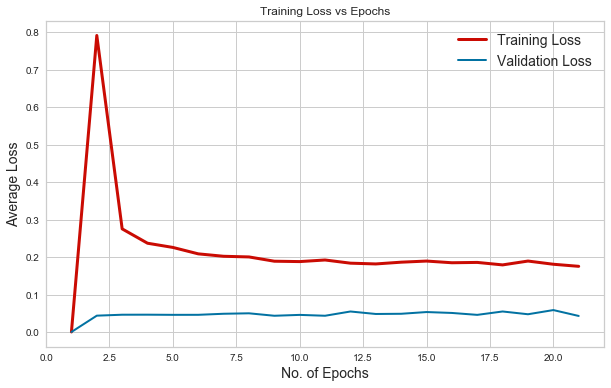

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,epochs+1), training_loss_list, "r-+", linewidth=3, label="Training Loss")
plt.plot(range(1,epochs+1), validation_loss_list, "b-", linewidth=2, label="Validation Loss")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("No. of Epochs", fontsize=14) 
plt.ylabel("Average Loss", fontsize=14) 
plt.title("Training Loss vs Epochs")
plt.show()

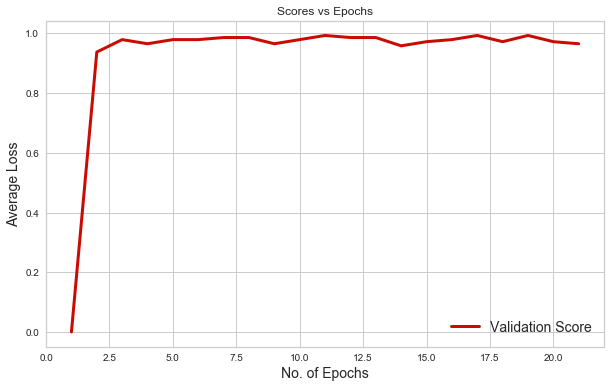

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,epochs+1), val_score_list, "r-+", linewidth=3, label="Validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("No. of Epochs", fontsize=14) 
plt.ylabel("Average Loss", fontsize=14) 
plt.title("Scores vs Epochs")
plt.show()

In [23]:
print('Training Accuracy: ', accu_error(y_train,model.predict(X_train)[0])[0])
print('\nTest - No. of correct predictions: %d/%d' %(accu_error(y_train,model.predict(X_train)[0])[0]*len(X_train), len(y_train)))

train_confusion_matrix = cm(y_train, model.predict(X_train)[0])
print('\nTrain - Confusion Matrix:\n', train_confusion_matrix)

precision_values = precision(train_confusion_matrix)
recall_values = recall(train_confusion_matrix)
f1_score_values = f1_score(train_confusion_matrix)

d = np.zeros((10,3))

for i in range(10):
    d[i][0] = precision_values[i]
    d[i][1] = recall_values[i]
    d[i][2] = f1_score_values[i]
df = pd.DataFrame(d, columns=['precision' ,'recall', 'f1_score'])

print('\nTrain - Classification Report')
print(df)

Training Accuracy:  0.988169798190675

Test - No. of correct predictions: 1420/1437

Train - Confusion Matrix:
 [[143   0   0   0   0   0   0   0   0   0]
 [  0 139   1   0   0   2   1   0   3   0]
 [  0   0 142   0   0   0   0   0   0   0]
 [  0   0   0 146   0   0   0   0   0   0]
 [  0   0   0   0 141   0   1   1   0   1]
 [  0   0   0   0   0 144   0   0   0   1]
 [  0   0   0   0   0   0 144   0   0   0]
 [  0   0   0   0   0   1   0 142   0   0]
 [  0   0   0   0   0   1   0   0 140   0]
 [  0   0   0   1   0   1   0   0   2 139]]

Train - Classification Report
   precision    recall  f1_score
0   1.000000  1.000000  1.000000
1   1.000000  0.952055  0.975439
2   0.993007  1.000000  0.996491
3   0.993197  1.000000  0.996587
4   1.000000  0.979167  0.989474
5   0.966443  0.993103  0.979592
6   0.986301  1.000000  0.993103
7   0.993007  0.993007  0.993007
8   0.965517  0.992908  0.979021
9   0.985816  0.972028  0.978873


In [24]:
print('Test Accuracy: ', test_accuracy)
print('\nTest - No. of correct predictions: %d/%d' %(test_accuracy*len(y_test), len(y_test)))

test_confusion_matrix = cm(y_test, y_pred)
print('\nTest - Confusion Matrix:\n', test_confusion_matrix)

precision_values = precision(test_confusion_matrix)
recall_values = recall(test_confusion_matrix)
f1_score_values = f1_score(test_confusion_matrix)

classification_list = []
classification_list.append([precision_values])
classification_list.append([recall_values])
classification_list.append([f1_score_values])
d = np.zeros((10,3))

for i in range(10):
    d[i][0] = precision_values[i]
    d[i][1] = recall_values[i]
    d[i][2] = f1_score_values[i]
df = pd.DataFrame(d, columns=['precision' ,'recall', 'f1_score'])

print('\nTest - Classification Report')
print(df)

Test Accuracy:  0.9194444444444444

Test - No. of correct predictions: 331/360

Test - Confusion Matrix:
 [[33  0  0  0  1  0  1  0  0  0]
 [ 0 30  0  2  0  0  0  0  0  4]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  1 29  0  3  0  0  4  0]
 [ 0  0  0  0 34  0  0  0  3  0]
 [ 0  0  0  0  0 37  0  0  0  0]
 [ 0  1  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 35  1  0]
 [ 0  1  0  1  0  2  0  0 29  0]
 [ 0  0  0  1  0  2  0  0  1 33]]

Test - Classification Report
   precision    recall  f1_score
0   1.000000  0.942857  0.970588
1   0.937500  0.833333  0.882353
2   0.972222  1.000000  0.985915
3   0.878788  0.783784  0.828571
4   0.971429  0.918919  0.944444
5   0.840909  1.000000  0.913580
6   0.972973  0.972973  0.972973
7   1.000000  0.972222  0.985915
8   0.763158  0.878788  0.816901
9   0.891892  0.891892  0.891892
